In [1]:
import tensorflow as tf
import numpy as np
import cv2
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import SGD
from imutils import build_montages
import matplotlib.pyplot as plt
from models import ResNet

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
# function to Load dataset

# Create a-z dataset
def load_az_dataset(path):
    # Intialise list data and lables
    data_az = []
    labels_az = []

    #Loop over the row of the a-z datset
    for row in open(path):
        # save each cell of the row in list
        row  = row.split(",")
        label = int(row[0])
        image = np.array([int(x) for x in row[1:]],dtype = "uint8")

        # convert image to 28*28 matrix
        image = np.reshape(image,(28,28))

        # add image and labels to dataset list
        data_az.append(image)
        labels_az.append(label)

    # Convert the list to numpy array
    data_az = np.array(data_az,dtype="float32")
    labels_az = np.array(labels_az,dtype="int")

    # return 2-tuple of the a-z data and labels
    return (data_az,labels_az)

# Load mnist dataset
def load_mnist_dataset():
    # Load mnist dataset and combine test and train data
    ((train,train_label),(test,test_label)) = tf.keras.datasets.mnist.load_data()
    data = np.vstack([train,test])
    labels = np.hstack([train_label,test_label])

    return (data,labels)

In [3]:
# Load az dataset
data_az , labels_az = load_az_dataset("/home/stark/Desktop/A_Z Handwritten Data.csv")


In [4]:
# Load 09 dataset
data_09 , labels_09 = load_mnist_dataset()

In [5]:
# Add 10 to labels_az so that first 10 labels can be 0-9 from mnist dataset
labels_az += 10

# Merge both dataset
data = np.vstack([data_09,data_az])
labels = np.hstack([labels_09,labels_az])

# Resize image to 32*32
data = [cv2.resize(image,(32,32)) for image in data]
data = np.array(data,dtype="float32")

# add a channel dimension to every image in the dataset and scale the
# pixel intensities of the images from [0, 255] down to [0, 1]
data = np.expand_dims(data, axis=-1)
data /= 255.0

In [6]:
# convert the labels from integers to vectors
le = LabelBinarizer()
labels = le.fit_transform(labels)

In [7]:
# account for skew in the labeled data
classTotals = labels.sum(axis=0)
classWeight = {}

# loop over all classes and calculate the class weight
for i in range(0, len(classTotals)):
	classWeight[i] = classTotals.max() / classTotals[i]

In [8]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data,labels, test_size=0.20, stratify=labels, random_state=42)

In [9]:
# construct the image generator for data augmentation
aug = tf.keras.preprocessing.image.ImageDataGenerator(
	rotation_range=10,
	zoom_range=0.05,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.15,
	horizontal_flip=False,
	fill_mode="nearest")

In [10]:
# initialize the number of epochs to train for, initial learning rate, and batch size

EPOCHS = 50
INIT_LR = 1e-1
BS = 128

# initialize and compile our deep neural network
opt = SGD(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model = ResNet.build(32, 32, 1, len(le.classes_), (3, 3, 3),(64, 64, 128, 256), reg=0.0005)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])


In [11]:
# train the network
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	validation_data=(testX, testY),
	steps_per_epoch=len(trainX) // BS,
	epochs=EPOCHS,
	class_weight=classWeight,
	verbose=1)

Epoch 1/50
2765/2765 [==============================] - 177s 64ms/step - loss: 1.8561 - accuracy: 0.8706 - val_loss: 0.4663 - val_accuracy: 0.9385
Epoch 2/50
2765/2765 [==============================] - 179s 65ms/step - loss: 0.9221 - accuracy: 0.9307 - val_loss: 0.4837 - val_accuracy: 0.9222
Epoch 3/50
2765/2765 [==============================] - 184s 67ms/step - loss: 0.8463 - accuracy: 0.9364 - val_loss: 0.5361 - val_accuracy: 0.8908
Epoch 4/50
2765/2765 [==============================] - 191s 69ms/step - loss: 0.8054 - accuracy: 0.9395 - val_loss: 0.5634 - val_accuracy: 0.8748
Epoch 5/50
2765/2765 [==============================] - 189s 68ms/step - loss: 0.7758 - accuracy: 0.9419 - val_loss: 0.5358 - val_accuracy: 0.8863
Epoch 6/50
2765/2765 [==============================] - 192s 69ms/step - loss: 0.7552 - accuracy: 0.9443 - val_loss: 0.4909 - val_accuracy: 0.9049
Epoch 7/50
2765/2765 [==============================] - 195s 70ms/step - loss: 0.7413 - accuracy: 0.9457 - val_loss: 0

In [12]:
# define the list of label names
labelNames = "0123456789"
labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labelNames = [l for l in labelNames]

In [14]:
# evaluate the network
predictions = model.predict(testX, batch_size=BS)
print(classification_report(testY.argmax(axis=1),predictions.argmax(axis=1), target_names=labelNames))

precision    recall  f1-score   support

           0       0.68      0.45      0.54      1381
           1       0.98      0.98      0.98      1575
           2       0.95      0.95      0.95      1398
           3       0.98      0.99      0.99      1428
           4       0.94      0.98      0.96      1365
           5       0.70      0.95      0.81      1263
           6       0.98      0.97      0.98      1375
           7       0.98      0.99      0.99      1459
           8       0.98      0.99      0.99      1365
           9       0.99      0.98      0.99      1392
           A       1.00      0.99      0.99      2774
           B       0.99      0.99      0.99      1734
           C       0.99      0.99      0.99      4682
           D       0.89      0.99      0.94      2027
           E       0.99      0.99      0.99      2288
           F       0.96      0.99      0.97       232
           G       0.96      0.97      0.97      1152
           H       0.98      0.98      0.

In [10]:
#model.save("best_model",save_format="h5")
model = tf.keras.models.load_model("best_model")


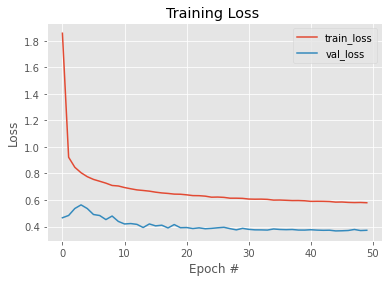

In [19]:
# construct a plot that plots and saves the training history
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss ")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.savefig("plot")

In [17]:
# initialize our list of output test images
images = []
# randomly select a few testing characters
for i in np.random.choice(np.arange(0, len(testY)), size=(49,)):
	# classify the character
	probs = model.predict(testX[np.newaxis, i])
	prediction = probs.argmax(axis=1)
	label = labelNames[prediction[0]]
	# extract the image from the test data and initialize the text
	# label color as green (correct)
	image = (testX[i] * 255).astype("uint8")
	color = (0, 255, 0)
	# otherwise, the class label prediction is incorrect
	if prediction[0] != np.argmax(testY[i]):
		color = (0, 0, 255)
	# merge the channels into one image, resize the image from 32x32
	# to 96x96 so we can better see it and then draw the predicted
	# label on the image
	image = cv2.merge([image] * 3)
	image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR)
	cv2.putText(image, label, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.75,color, 2)
	# add the image to our list of output images
	images.append(image)
# construct the montage for the images
montage = build_montages(images, (96, 96), (7, 7))[0]
# show the output montage
cv2.imshow("OCR Results", montage)
cv2.waitKey(0)

